## In class, we applied DWNN to perform predictions over the NOAA dataset. The input space ended up having 6 dimensions, which makes it hard to visualize.

## We want a mathematical approach to detect whether the points in input space follow the shape to which DWNN is weak.

In [1]:
# We assume that each row in the dataset follows (x1, x2, ..., xN, y),
#   with y as last element
# @param dataset Must be a matrix or data.frame
# @param query Can be a single number, a vector or a matrix whose rows are query points.
# @param sigma The hyperparameter of the DWNN.
dwnn = function(dataset, query, sigma){
    dataset = as.matrix(dataset)
    if(!is.matrix(query)) # assume it is a vector
        query = as.matrix(query, nrow=1)
    
    X = as.matrix(dataset[,1:(ncol(dataset)-1)], ncol=(ncol(dataset)-1))
    Y = dataset[,ncol(dataset)]
    
    Z = apply(query, 1, function(queryRow){
        dists = apply(X, 1, function(row){
            sqrt(sum(
                (row - queryRow)**2
            ))
        })
        activations = exp(-dists**2 / (2*sigma**2))
        return( (activations %*% Y) / sum(activations) )
    })

    if(is.matrix(query))
        return(Z)
    else
        return(as.numeric(Z))
}

## Let's see if it's working

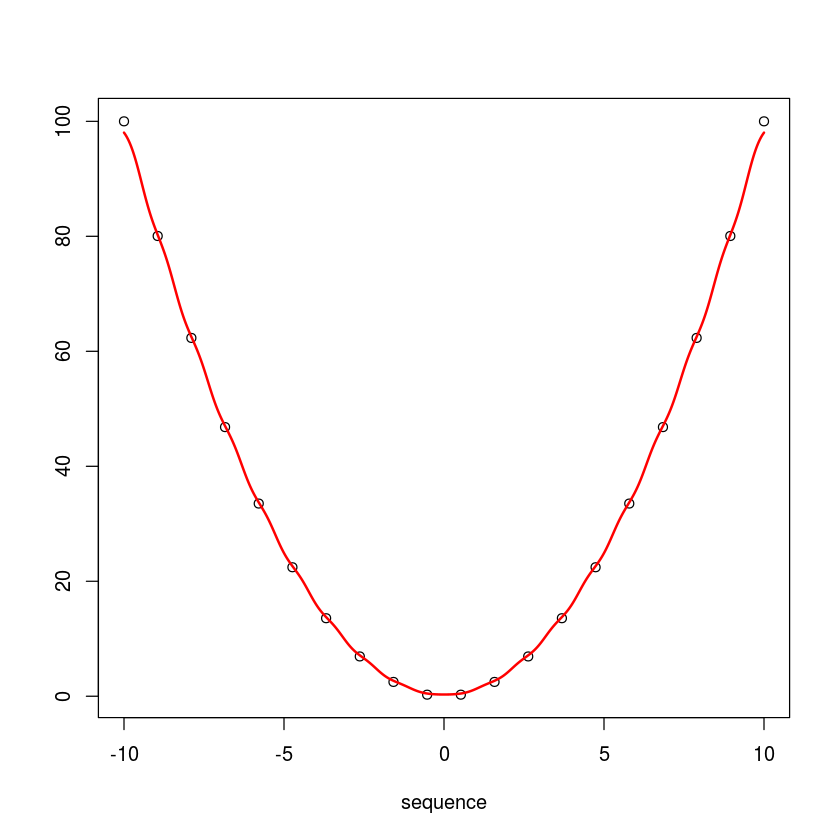

In [2]:
sequence = seq(-10, 10, length=20)
dataset = cbind(sequence, sequence**2)

x = seq(-10, 10, length=1000)
query = matrix(x, ncol=1)

result = dwnn(dataset, query, sigma = 0.5)

plot(dataset)
points(cbind(query, result), col=2, type="l", lwd=2)

## Now let's see what happens when the X in the dataset is not evenly spaced

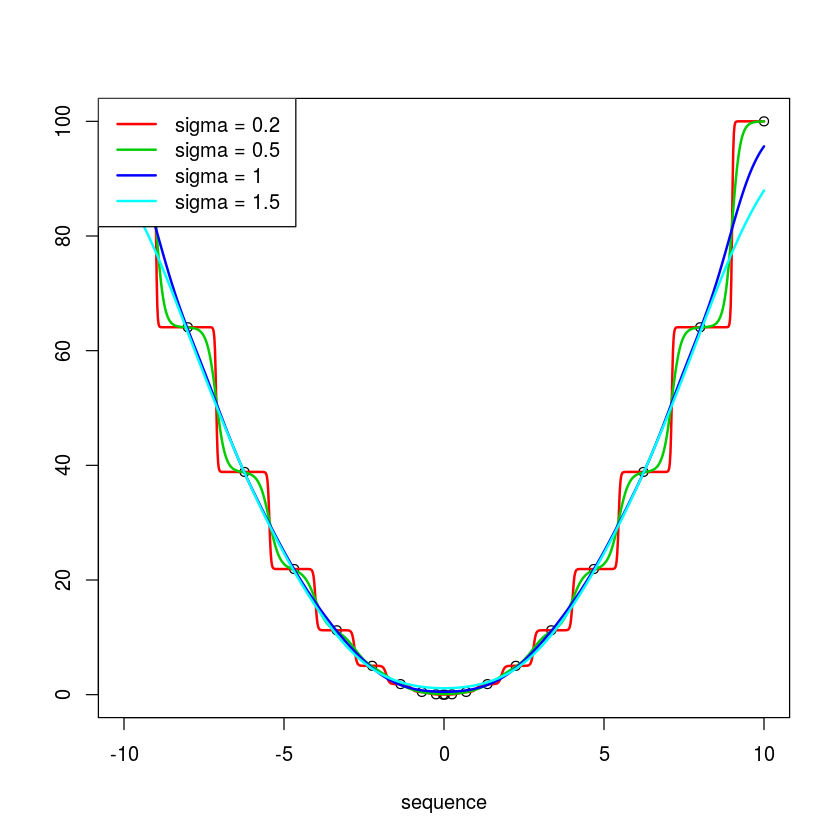

In [3]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-10, 10, length=1000)
query = matrix(x, ncol=1)

plot(dataset)

allSigmas = c(0.2, 0.5, 1, 1.5)
for(i in 1:length(allSigmas)){
    result = dwnn(dataset, query, sigma = allSigmas[i])
    points(cbind(query, result), col=i+1, type="l", lwd=2)
}
legend("topleft", legend=paste("sigma =", allSigmas), col=1:length(allSigmas)+1, lwd=2)

## The biggest problem is actually when the new point x is far from the other points

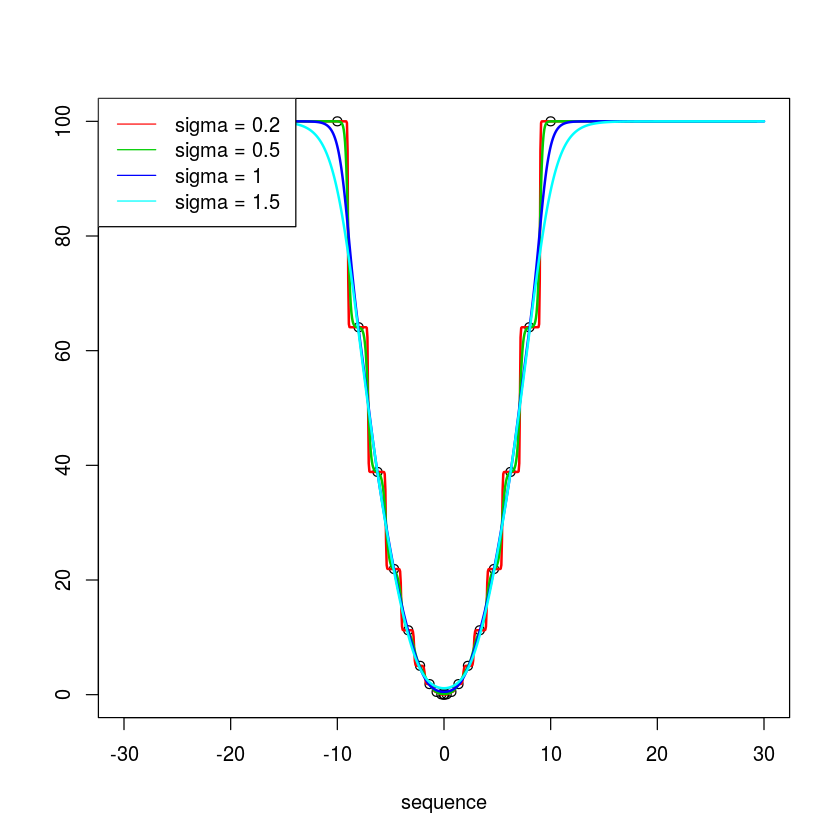

In [4]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-30, 30, length=1000)
query = matrix(x, ncol=1)

plot(dataset, xlim = c(-30, 30))

allSigmas = c(0.2, 0.5, 1, 1.5)
for(i in 1:length(allSigmas)){
    result = dwnn(dataset, query, sigma = allSigmas[i])
    points(cbind(query, result), col=i+1, type="l", lwd=2)
}
legend("topleft", legend=paste("sigma =", allSigmas), col=1:length(allSigmas)+1, lwd=1)

## We could say that the prediction is "bad" when the new point $\hat{x}$ is not "surrounded" by other points from the dataset.

## How can we detect "surroundedness"?

## We thought of taking all difference vectors

$$
    v_i = \hat{x} - x_i
$$

## And then calculating the angle between each of these vectors, using the formula

$$
    cos(\theta) = \frac{<v_i, v_j>}{||v_i|| \;||v_j||}
$$

## Then we expect that the variance of all cosines is low whenever the points is not "surrounded" by other points.

## Let's test this for the example used above.

In [5]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-30, 30, length=100)
query = matrix(x, ncol=1)

# Returns the norm2 of each line in matrix v1
norm2 = function(v1){
    if(!is.matrix(v1))
        v1 = matrix(v1, ncol=length(v1))
    
    return(sqrt(
        apply(v1, 1, function(row) sum(row**2))
    ))
}

# Returns the cosine between each pair of rows from v1 and v2
cosine = function(v1, v2){
    if(!is.matrix(v1))
        v1 = as.matrix(v1, ncol=length(v1))    
    if(!is.matrix(v2))
        v2 = as.matrix(v2, ncol=length(v2))

    v2norms = norm2(v2)

    return(
        apply(v1, 1, function(v1row){
            aux = t(v1row) %*% t(v2)
            return( as.numeric(aux / (norm2(v1row) * v2norms)) )
        })
    )
}

#apply(query, 1, function(queryRow){
#    cosines = apply(dataset, 1, function(row){
#        cosine(queryRow, row[1])
#    })
#    print(cosines)
#    return(var(cosines))
#})
q = query[55,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")
           
q = query[20,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")
           
q = query[90,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")

[1] 2.727273
Mean:  0.2105263 
Variance:  0.980171 
[1] -18.48485
Mean:  1 
Variance:  0 
[1] 23.93939
Mean:  1 
Variance:  0 


## Let us try a better benchmark.

## Let's try datasets with a form such as an N-dimensional sphere with radius 1; then a point (1.5, ..., 1.5) should be deemed as "not surrounded", whereas (0.5, ..., 0.5) as "surrounded".

In [7]:
spherical_dataset = function(dim=3, rows=1000){
    result = matrix(rnorm(n=dim*rows, mean=0, sd=1), ncol=dim, nrow=rows)
    result[result > 1] = 1
    result[result < -1] = -1
    return(result)
}

hypercubic_dataset = function(dim=3, rows=1000){
    result = matrix(runif(n=dim*rows, min=-1, max=1), ncol=dim, nrow=rows)
    result[result > 1] = 1
    result[result < -1] = -1
    return(result)
}

test.cosines = function(dims=c(3, 6, 9, 12), dataset_func=spherical_dataset){
    get.var.mean = function(query, dataset){
        diff = query - dataset
        cos = cosine(diff, diff)
        cos = cos[upper.tri(cos)]
        cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
        return( c(var(cos), mean(cos), max(cos), min(cos)) )
    }
    
    for(dim in dims){
        cat("Dimension: ", dim, "\n")
        
        dataset = dataset_func(dim=dim, rows=5**3)
        badQuery = rep(1.5, dim)
        avgQuery = rep(0.75, dim)
        goodQuery = rep(0, dim)
        
        stats = get.var.mean(badQuery, dataset)
        cat("\tBad query:  variance = ", stats[1], " mean = ", stats[2], " max = ", stats[3], " min = ", stats[4], "\n")
        
        stats = get.var.mean(-badQuery, dataset)
        cat("\t-Bad query:  variance = ", stats[1], " mean = ", stats[2], " max = ", stats[3], " min = ", stats[4], "\n")

        stats = get.var.mean(avgQuery, dataset)
        cat("\tAvg query:  variance = ", stats[1], " mean = ", stats[2], " max = ", stats[3], " min = ", stats[4], "\n")
        
        stats = get.var.mean(goodQuery, dataset)
        cat("\tGood query:  variance = ", stats[1], " mean = ", stats[2], " max = ", stats[3], " min = ", stats[4], "\n")
    }
}

cat("Spherical\n\n")
test.cosines(dataset_func=spherical_dataset)
cat("\n\nHypercubic\n\n")
test.cosines(dataset_func=hypercubic_dataset)

Spherical

Dimension:  3 
	Bad query:  variance =  0.0124203  mean =  0.8678902  max =  0.9999972  min =  0.4074142 
	-Bad query:  variance =  0.01449011  mean =  0.857893  max =  0.9999992  min =  0.4124983 
	Avg query:  variance =  0.1962854  mean =  0.5097427  max =  0.9999936  min =  -0.9995369 
	Good query:  variance =  0.3364036  mean =  0.006402277  max =  0.9999856  min =  -0.9999751 
Dimension:  6 
	Bad query:  variance =  0.008731368  mean =  0.8269729  max =  0.9953203  min =  0.4593014 
	-Bad query:  variance =  0.006684073  mean =  0.8467776  max =  0.9944326  min =  0.4968953 
	Avg query:  variance =  0.07500569  mean =  0.48352  max =  0.9867931  min =  -0.688822 
	Good query:  variance =  0.1653118  mean =  0.003261875  max =  0.9684605  min =  -0.977164 
Dimension:  9 
	Bad query:  variance =  0.005703357  mean =  0.8244063  max =  0.98922  min =  0.5198453 
	-Bad query:  variance =  0.005339572  mean =  0.8277954  max =  0.988061  min =  0.5147246 
	Avg query:  varian

## Good thing 1: The mean is nearer to 0 when the point is "surrounded"

## Good thing 2: The variance is higher when the point is "surrounded"

## Bad thing 1: The scale for the variance differs when the dimension increases

## Another way of checking if a point is surrounded is to see whether the point is inside the polytope defined by all the points of the dataset. This is not trivial, as it involves finding the convex hull formed by the points.

## Let's now see whether the NOAA dataset is fine or not

In [9]:
require(tseriesChaos)
require(EMD)
require(rgl)

Loading required package: tseriesChaos
Loading required package: EMD
Loading required package: fields
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.4-0 (2019-11-01) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:R.utils’:

    cleanup

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22

Attaching package: ‘EMD’

The following object is masked from ‘package:R.utils’:

    unwrap

Loading required package: rgl


In [10]:
# Reading Paris.csv
data = read.csv("Paris.csv")
id = which(data[,"NAME"] == "ORLY, FR")
tmax = data[id, "TMAX"]
tmax = tmax[2600:(2600 + 25345 - 1)]

# Embedding
res = emd(tmax, boundary="wave")
stochastic = rowSums(res$imf[,1:3])
deterministic = rowSums(res$imf[,4:res$nimf]) + res$residue
emb = embedd(deterministic, m=7, d=74)

In [11]:
# We will check from here
begin = nrow(emb) - 20

# We don't have enough memory, so we define another function to get cosines
cosine2 = function(diff){
    allCosines = rep(0, nrow(diff)-1)
    
    for(i in 2:nrow(diff)){
        v1 = diff[i-1,]
        v2 = diff[i,]
        allCosines[i-1] = (v1 %*% v2) / (norm2(v1) * norm2(v2))
    }
    return(allCosines)
}

df = NULL

for(i in begin:nrow(emb)){
    # x_1 x_3 x_5
    # x_2 x_4 x_6
    # x_3 x_5 x_7
    #
    # We always use the first 1:(length-1) to predict the next
    # So we have to check 1:(length-1) against the rest of the dataset
    query = emb[i,1:(ncol(emb)-1)]
    diff = query - emb[1:(i-1),1:(ncol(emb)-1)]
    cos = cosine2(diff)
#   message(paste(paste("sd = ", s, "    mean = ", m)))
    df = rbind(df, c(sd(cos), mean(cos), max(cos), min(cos)))
}

colnames(df) = c("StdDev", "Mean", "Max", "Min")
df

StdDev,Mean,Max,Min
0.1387133,0.6603462,0.9154819,-0.1607527
0.2935201,0.5759950,0.9045135,-0.9177943
0.3347231,0.7170270,0.9958638,-0.5987745
0.2715703,0.5891085,0.9541494,-0.8645115
0.1516329,0.6726101,0.9295178,-0.3580197
0.2520033,0.7196885,0.9788554,-0.5505960
0.1760018,0.6855402,0.9466705,-0.1927466
0.2790562,0.6211733,0.9346946,-0.8971265
0.2907593,0.7327582,0.9988935,-0.5417286
0.2626418,0.6480314,0.9859250,-0.8987136


In [13]:
summary(df)

     StdDev            Mean             Max              Min         
 Min.   :0.1387   Min.   :0.5760   Min.   :0.9045   Min.   :-0.9637  
 1st Qu.:0.2121   1st Qu.:0.6603   1st Qu.:0.9541   1st Qu.:-0.8810  
 Median :0.2520   Median :0.7170   Median :0.9734   Median :-0.5417  
 Mean   :0.2459   Mean   :0.6869   Mean   :0.9675   Mean   :-0.5576  
 3rd Qu.:0.2908   3rd Qu.:0.7265   3rd Qu.:0.9839   3rd Qu.:-0.3580  
 Max.   :0.3347   Max.   :0.7393   Max.   :1.0000   Max.   :-0.1334  

## Instead of taking cosines from all other points, what if we considered just the nearest ones?

In [14]:
df = NULL

sigma = 4.763158 # Sigma we used in class

for(i in begin:nrow(emb)){
    query = emb[i,1:(ncol(emb)-1)]
    trainSet = emb[1:(i-1),]
    
    # Get the activations (the same used in dwnn)
    dists = apply(trainSet, 1, function(row){
        sqrt(sum(row[1:(length(row)-1)] - query)**2)
    })
    activations = exp(-dists**2 / (2*sigma**2))
    
    # Normalize activations
    activations = activations / sum(activations)

    idx = sort.list(activations, decreasing=TRUE)
    activations = activations[idx]
    trainSet = trainSet[idx,]
    
    # We want to get the points that make their cumulative activations > 90%
    acc = cumsum(activations)
    id = which(acc > 0.9)[1]
    
    trainSet = trainSet[1:id,]

    if(nrow(trainSet) > 1){
        diff = query - trainSet[,1:(ncol(trainSet)-1)]
        cos = cosine(diff, diff)
        cos = cos[upper.tri(cos)]
        cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
    } else {
        cos = NA
    }
    #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
    df = rbind(df, c(id, id / (i-1), sd(cos), mean(cos), max(cos), min(cos)))
}

colnames(df) = c("Abs. Cutoff", "Rel. Cutoff", "StdDev", "Mean", "Max", "Min")
df

Abs. Cutoff,Rel. Cutoff,StdDev,Mean,Max,Min
4759,0.1912781,0.5325228,0.1409926,0.9999617,-0.9995052
4721,0.1897432,0.5317972,0.1446089,0.9999657,-0.9998972
4702,0.1889719,0.4445516,0.1701967,0.9999702,-0.9995741
4700,0.1888840,0.4455579,0.1701182,0.9999602,-0.9990544
4704,0.1890371,0.5191863,0.1846877,0.9999782,-0.9996858
4702,0.1889492,0.4476001,0.1727162,0.9999733,-0.9994769
4696,0.1887005,0.4490011,0.1719860,0.9999781,-0.9988354
4690,0.1884518,0.4514236,0.1714380,0.9999648,-0.9996880
4679,0.1880023,0.5384181,0.1528141,0.9999741,-0.9994456
4653,0.1869501,0.4979993,0.1859938,0.9999920,-0.9998364


In [15]:
summary(df)

  Abs. Cutoff    Rel. Cutoff         StdDev            Mean             Max   
 Min.   :3659   Min.   :0.1470   Min.   :0.4446   Min.   :0.1244   Min.   :1  
 1st Qu.:3909   1st Qu.:0.1570   1st Qu.:0.4716   1st Qu.:0.1399   1st Qu.:1  
 Median :4596   Median :0.1847   Median :0.5192   Median :0.1702   Median :1  
 Mean   :4350   Mean   :0.1748   Mean   :0.5099   Mean   :0.1602   Mean   :1  
 3rd Qu.:4700   3rd Qu.:0.1889   3rd Qu.:0.5510   3rd Qu.:0.1749   3rd Qu.:1  
 Max.   :4759   Max.   :0.1913   Max.   :0.5666   Max.   :0.1883   Max.   :1  
      Min         
 Min.   :-1.0000  
 1st Qu.:-0.9997  
 Median :-0.9996  
 Mean   :-0.9993  
 3rd Qu.:-0.9994  
 Max.   :-0.9958  

### Can we find the optimal sigma only using the cosines?

In [18]:
sigmaDf = NULL

for(sigma in seq(0.5, 5, by=0.25)){
    df = NULL
    warning(sigma);
    for(i in begin:nrow(emb)){
        query = emb[i,1:(ncol(emb)-1)]
        trainSet = emb[1:(i-1),]

        # Get the activations (the same used in dwnn)
        dists = apply(trainSet, 1, function(row){
            sqrt(sum(row[1:(length(row)-1)] - query)**2)
        })
        activations = exp(-dists**2 / (2*sigma**2))

        # Normalize activations
        activations = activations / sum(activations)

        idx = sort.list(activations, decreasing=TRUE)
        activations = activations[idx]
        trainSet = trainSet[idx,]

        # We want to get the points that make their cumulative activations > 90%
        acc = cumsum(activations)
        id = which(acc > 0.9)[1]

        trainSet = trainSet[1:id,]

        if(nrow(trainSet) > 1){
            diff = query - trainSet[,1:(ncol(trainSet)-1)]
            cos = cosine(diff, diff)
            cos = cos[upper.tri(cos)]
            cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
        } else {
            cos = NA
        }
        #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
        df = rbind(df, c(id, id / (i-1), sd(cos), mean(cos), max(cos), min(cos)))
    }

    colnames(df) = c("Abs. Cutoff", "Rel. Cutoff", "StdDev", "Mean", "Max", "Min")
    sigmaDf = rbind(sigmaDf, c(sigma, mean(df[,"Mean"]), mean(df[,"Min"])))
}

sigmaDf

Warning message in eval(expr, envir, enclos):
“0.5”Warning message in eval(expr, envir, enclos):
“0.75”Warning message in eval(expr, envir, enclos):
“1”Warning message in eval(expr, envir, enclos):
“1.25”Warning message in eval(expr, envir, enclos):
“1.5”Warning message in eval(expr, envir, enclos):
“1.75”Warning message in eval(expr, envir, enclos):
“2”Warning message in eval(expr, envir, enclos):
“2.25”Warning message in eval(expr, envir, enclos):
“2.5”Warning message in eval(expr, envir, enclos):
“2.75”Warning message in eval(expr, envir, enclos):
“3”Warning message in eval(expr, envir, enclos):
“3.25”Warning message in eval(expr, envir, enclos):
“3.5”Warning message in eval(expr, envir, enclos):
“3.75”Warning message in eval(expr, envir, enclos):
“4”Warning message in eval(expr, envir, enclos):
“4.25”Warning message in eval(expr, envir, enclos):
“4.5”Warning message in eval(expr, envir, enclos):
“4.75”Warning message in eval(expr, envir, enclos):
“5”

0.50,0.1707918,-0.9961620
0.75,0.1685708,-0.9966479
1.00,0.1748449,-0.9971171
1.25,0.1733913,-0.9980767
1.50,0.1694025,-0.9982483
1.75,0.1719647,-0.9988740
2.00,0.1688032,-0.9990083
2.25,0.1741621,-0.9986204
2.50,0.1700458,-0.9988744
2.75,0.1624095,-0.9992292
3.00,0.1675656,-0.9991697


### How about the gasoline prices dataset?

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

5 
4 


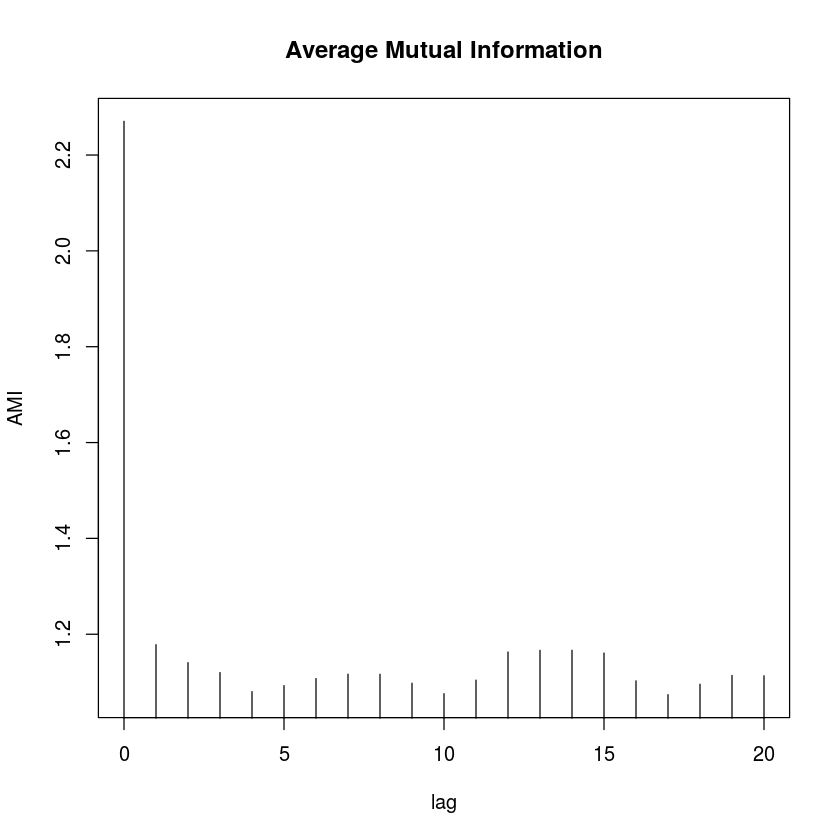

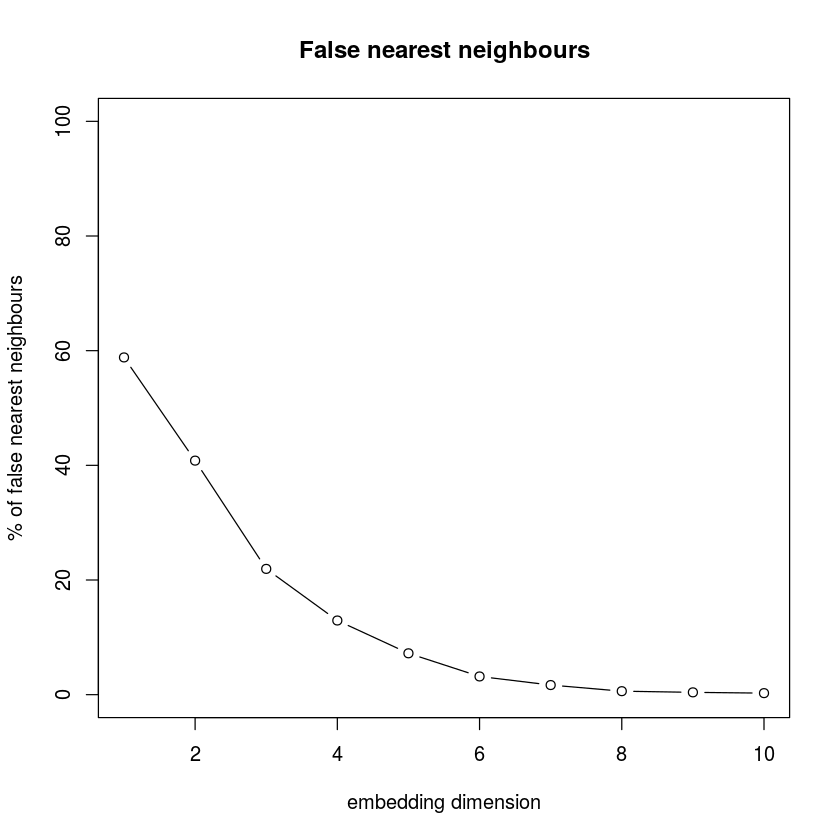

In [25]:
dataframe = read.table("2004-2019.tsv",sep="\t",header=T)
oil = dataframe[which(dataframe["PRODUTO"] == "GASOLINA COMUM"),"PREÇO.MÉDIO.DISTRIBUIÇÃO"]
oil = as.numeric(as.character(oil))

# N/A values will be averaged over 3 neighbor samples
for(i in which(is.na(oil))){
    neighbors = (i-3):(i+3)
    neighbors = neighbors[!is.na(oil[neighbors])]
    oil[i] = mean(oil[neighbors])
}

res = mutual(oil)
d = which(diff(res) > 0)[1] - 1
print(d)
res = false.nearest(oil, d=d, m=10, t=180)
plot(res)

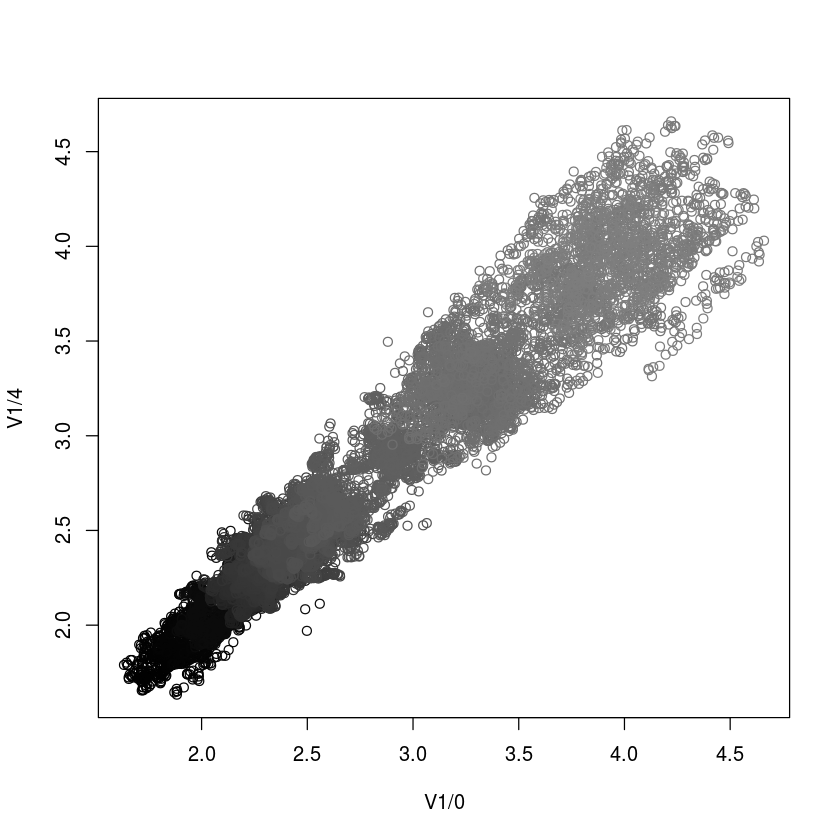

In [27]:
emb = embedd(oil, d=4, m=2)
plot(embedd(oil, d=4, m=2), col=gray(seq(0, 0.5, length=nrow(emb))))

## So $d = 4$ and $m = 8$

In [20]:
sigmaDf = NULL

emb = embedd(oil, d=4, m=8)
begin = nrow(emb) - 20

for(sigma in seq(0.5, 4, by=0.25)){
    df = NULL
    warning(sigma);
    for(i in begin:nrow(emb)){
        query = emb[i,1:(ncol(emb)-1)]
        trainSet = emb[1:(i-1),]

        # Get the activations (the same used in dwnn)
        dists = apply(trainSet, 1, function(row){
            sqrt(sum(row[1:(length(row)-1)] - query)**2)
        })
        activations = exp(-dists**2 / (2*sigma**2))

        # Normalize activations
        activations = activations / sum(activations)

        idx = sort.list(activations, decreasing=TRUE)
        activations = activations[idx]
        trainSet = trainSet[idx,]

        # We want to get the points that make their cumulative activations > 90%
        acc = cumsum(activations)
        id = which(acc > 0.9)[1]

        trainSet = trainSet[1:id,]

        if(nrow(trainSet) > 1){
            diff = query - trainSet[,1:(ncol(trainSet)-1)]
            cos = cosine(diff, diff)
            cos = cos[upper.tri(cos)]
            cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
        } else {
            cos = NA
        }
        #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
        df = rbind(df, c(id, id / (i-1), sd(cos), mean(cos), max(cos), min(cos)))
    }

    colnames(df) = c("Abs. Cutoff", "Rel. Cutoff", "StdDev", "Mean", "Max", "Min")
    sigmaDf = rbind(sigmaDf, c(sigma, mean(df[,"Abs. Cutoff"]), mean(df[,"Mean"]), mean(df[,"Min"])))
}

sigmaDf

Warning message in eval(expr, envir, enclos):
“0.5”Warning message in eval(expr, envir, enclos):
“0.75”Warning message in eval(expr, envir, enclos):
“1”Warning message in eval(expr, envir, enclos):
“1.25”Warning message in eval(expr, envir, enclos):
“1.5”Warning message in eval(expr, envir, enclos):
“1.75”Warning message in eval(expr, envir, enclos):
“2”Warning message in eval(expr, envir, enclos):
“2.25”Warning message in eval(expr, envir, enclos):
“2.5”Warning message in eval(expr, envir, enclos):
“2.75”Warning message in eval(expr, envir, enclos):
“3”Warning message in eval(expr, envir, enclos):
“3.25”Warning message in eval(expr, envir, enclos):
“3.5”Warning message in eval(expr, envir, enclos):
“3.75”Warning message in eval(expr, envir, enclos):
“4”

0.50,832.1429,0.0011108889,-0.9865761
0.75,1203.0952,-0.0001764905,-0.9906052
1.00,1481.8571,0.0048848827,-0.9929436
1.25,1678.1429,0.0110257856,-0.9943726
1.50,1843.2857,0.0168681625,-0.9937688
1.75,2027.2857,0.0194692922,-0.9946500
2.00,2279.7143,0.0270937843,-0.9956279
2.25,2720.4286,0.0802581216,-0.9965284
2.50,3235.2381,0.1533038916,-0.9964934
2.75,3672.5238,0.2115585864,-0.9976047
3.00,4027.1905,0.2548515190,-0.9972365


In [34]:
df = NULL

emb = embedd(oil, d=4, m=8)
print(nrow(emb))
emb = emb[1:(nrow(emb)-5000),]
begin = nrow(emb) - 20
sigma = 2.5

for(i in begin:nrow(emb)){
    query = emb[i,1:(ncol(emb)-1)]
    trainSet = emb[1:(i-1),]
    
    # Get the activations (the same used in dwnn)
    dists = apply(trainSet, 1, function(row){
        sqrt(sum(row[1:(length(row)-1)] - query)**2)
    })
    activations = exp(-dists**2 / (2*sigma**2))
    
    # Normalize activations
    activations = activations / sum(activations)

    idx = sort.list(activations, decreasing=TRUE)
    activations = activations[idx]
    trainSet = trainSet[idx,]
    
    # We want to get the points that make their cumulative activations > 90%
    acc = cumsum(activations)
    id = which(acc > 0.9)[1]
    
    trainSet = trainSet[1:id,]

    print(nrow(trainSet))
    if(nrow(trainSet) > 1){
        diff = query - trainSet[,1:(ncol(trainSet)-1)]
        cos = cosine(diff, diff)
        cos = cos[upper.tri(cos)]
        cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
    } else {
        cos = NA
    }
    s = sd(cos)
    m = mean(cos)
    #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
    df = rbind(df, c(id, id / (i-1), sd(cos), mean(cos), max(cos), min(cos)))
}

colnames(df) = c("Abs. Cutoff", "Rel. Cutoff", "StdDev", "Mean", "Max", "Min")
df

[1] 21166
[1] 7179
[1] 7685
[1] 7276
[1] 6918
[1] 7769
[1] 7510
[1] 7169
[1] 7079
[1] 7721
[1] 7786
[1] 6958
[1] 7014
[1] 7907
[1] 7554
[1] 7039
[1] 6751
[1] 7722
[1] 8003
[1] 6754
[1] 6762
[1] 7793


Abs. Cutoff,Rel. Cutoff,StdDev,Mean,Max,Min
7179,0.4446578,0.1421035,0.9004386,0.9999995,-0.9273141
7685,0.4759693,0.1640938,0.9203271,0.9999991,-0.9352768
7276,0.4506100,0.1387260,0.9232146,0.9999992,-0.9163584
6918,0.4284122,0.1290388,0.9069619,0.9999990,-0.9118029
7769,0.4810824,0.1729668,0.9207281,0.9999990,-0.9308595
7510,0.4650155,0.1548451,0.9210893,0.9999995,-0.9113335
7169,0.4438734,0.1358881,0.9219590,0.9999992,-0.9841474
7079,0.4382739,0.1390659,0.9064103,0.9999995,-0.9150817
7721,0.4779917,0.2056696,0.9301186,0.9999992,-0.9754054
7786,0.4819859,0.1772776,0.9132258,0.9999995,-0.9655457


In [35]:
df = NULL

emb = embedd(oil, d=4, m=8)
emb = emb[1:(nrow(emb)-5000),]
begin = nrow(emb) - 20
sigma = 0.5

for(i in begin:nrow(emb)){
    query = emb[i,1:(ncol(emb)-1)]
    trainSet = emb[1:(i-1),]
    
    # Get the activations (the same used in dwnn)
    dists = apply(trainSet, 1, function(row){
        sqrt(sum(row[1:(length(row)-1)] - query)**2)
    })
    activations = exp(-dists**2 / (2*sigma**2))
    
    # Normalize activations
    activations = activations / sum(activations)

    idx = sort.list(activations, decreasing=TRUE)
    activations = activations[idx]
    trainSet = trainSet[idx,]
    
    # We want to get the points that make their cumulative activations > 90%
    acc = cumsum(activations)
    id = which(acc > 0.9)[1]
    
    trainSet = trainSet[1:id,]

    diff = query - trainSet[,1:(ncol(trainSet)-1)]
    cos = cosine(diff, diff)
    #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
    df = rbind(df, c(id, id / (i-1), sd(cos), mean(cos), max(cos), min(cos)))
}

colnames(df) = c("Abs. Cutoff", "Rel. Cutoff", "StdDev", "Mean", "Max", "Min")
df

Abs. Cutoff,Rel. Cutoff,StdDev,Mean,Max,Min
130,0.008052028,0.3698549,0.10287848,1,-0.9273141
153,0.009476031,0.4143582,0.05440095,1,-0.9352768
135,0.008360686,0.3707354,0.11981002,1,-0.9524133
121,0.007493188,0.3614103,0.15241866,1,-0.9118029
160,0.009907734,0.3875310,0.04073023,1,-0.9405919
148,0.009164087,0.3881016,0.07701093,1,-0.9145836
134,0.008296700,0.3680325,0.13036260,1,-0.9841474
130,0.008048539,0.3676237,0.11311862,1,-0.9705885
161,0.009967189,0.4539393,0.04299217,1,-0.9480032
165,0.010214188,0.3891515,0.03210332,1,-0.9493030


### My guess is that the embedding is resulting in a some sort of "spiral", so the next point really is actually surrounded by other points of this spiral.